# Batch Example for Elvis

In this example the batch capabilities of Elvis shall be shown and visualised, meaning Elvis is used to basically perform a sensitivity analysis. In this example the changed parameter is the Infrastructure Design.

### Import the module
Make the modules available for the Notebook

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import yaml
import datetime

from copy import deepcopy
from elvis.config import ScenarioConfig, ScenarioRealisation
from elvis.simulate import simulate
from elvis.utility.elvis_general import create_time_steps, num_time_steps
from elvis.result import ElvisResult



#### Infrastructure set up
Since the infrastructure shall be switched up a function is implemented that creates Elvis conform infrastructure dictionaries based on the amount of low, middle and high cps specified.

In [3]:
def set_up_infrastructure(num_low, num_middle, num_high):
    # creates elvis conform infrastructure dict with the parameterised number of cps per power
    
    assert isinstance(num_low, int)
    assert isinstance(num_middle, int)
    assert isinstance(num_high, int)
    
    # Ensure sufficient transformer size so no restrictions occure
    power_transformer = num_low * 3.7 + num_middle * 22 + num_high * 150
    
    transformer = {'charging_stations': [], 'id': 'transformer1',
                   'min_power': 0, 'max_power': power_transformer}
    
    # One charging point per charging station
    num_cp_per_cs = 1
    
    # Low, middle and high power specifications. Just an example. These values could be anything.
    powers = [3.7, 22, 150]
    nums = [num_low, num_middle, num_high]
    counter = 1
    
    for i in range(len(powers)):
        power = powers[i]
        num = nums[i]
        
        charging_point = {'min_power': 0, 'max_power': power}
        charging_station = {'min_power': 0, 'max_power': power, 'charging_points': []}
        
        for i in range(num):
            charging_station_temp = deepcopy(charging_station)
            charging_station_temp['id'] = 'cs' + str(counter)
            
            for j in range(num_cp_per_cs):
                charging_point_temp = deepcopy(charging_point)
                charging_point_temp['id'] = 'cp' + str(counter)
                charging_station_temp['charging_points'].append(charging_point_temp)
                counter += 1
                
            transformer['charging_stations'].append(charging_station_temp)
        
    infrastructure = {'transformers': [transformer]}
    
    return infrastructure

#### KPI creator

This function is called for each result that is generated and calculates some KPIs before they are saved to a pandas DataFrame

In [4]:
def get_kpis(result, df_res, infrastructure, cp_code, num_events, start_date, end_date, res):
    assert isinstance(result, ElvisResult)
    
    res_row = [int(x) for x in cp_code.split('_')]
    
    num_steps = num_time_steps(start_date, end_date, res)
    result.aggregate_load_profile(num_steps)
    
    # Simultaneity factor
    res_row.append(result.simultaneity_factor(infrastructure=infrastructure, quantile=0.8))
    res_row.append(result.simultaneity_factor(infrastructure=infrastructure, quantile=0.95))
    res_row.append(result.simultaneity_factor(infrastructure=infrastructure))
    
    # Charging time
    res_row.append(result.average_charging_time(in_hours=True))
    
    # total charged energy and rejections
    res_row.append(result.total_energy_charged(res, num_steps))
    res_row.append(result.counter_rejections/num_events)
    
    df_res.loc[len(df_res), :] = res_row
    
    return

In [5]:
# Load inputs that are equal for all cases
with open(r'../data/config_builder/Batch_example.yaml', 'r') as fin:
    data = yaml.full_load(fin)

#### Grid Search
In order to find a suited infrastructure a grid search function is provided that takes in the ranges for the different configurations, simulates them and returns the KPIs

In [6]:
def elvis_cp_grid_search(range_low, range_middle, range_high, df_res):
    results = {}
    start_date = datetime.datetime(2020,1,1)
    end_date = datetime.datetime(2020,1,14)
    
    for num_cp_low in range_low:
        for num_cp_middle in range_middle:
            for num_cp_high in range_high:
                if num_cp_high > 0:
                    res = datetime.timedelta(minutes=5)
                else:
                    res = datetime.timedelta(minutes=15)
                
                # Identifier containing the different amounts of cp powers
                cp_code = str(num_cp_low) + '_' + str(num_cp_middle) + '_' + str(num_cp_high)
                
                start_time = time.time()
                
                # Create infrastructure for current run
                infrastructure = set_up_infrastructure(num_cp_low, num_cp_middle, num_cp_high)
                data['infrastructure'] = infrastructure
                config = ScenarioConfig.from_dict(data)
                realisation = config.create_realisation(start_date=start_date, end_date=end_date,
                                 resolution=res)
                
                result = simulate(realisation, print_progress=False)
                results[cp_code] = result
                end_time = time.time()
                
                # Get KPIs for current run
                get_kpis(result, df_res, infrastructure, cp_code, len(realisation.charging_events), start_date, end_date, res)
                print(cp_code + ': ' + str(end_time - start_time))
            
                
    return results
                

#### Call grid search function
KPIs will be stored in df_res, results will contain the ELVIS result class for each simulation.

In this example run the simulation for a couple of batch cases for only 2 weeks with moderate timewise resolution. Especially the length of the simulation should be longer for better conversion.

In [8]:
# Setup DataFrame
cols = []
cols.append('cps_low')
cols.append('cps_middle')
cols.append('cps_high')
cols.append('quant80')
cols.append('quant95')
cols.append('quant100')
cols.append('avg_charge_time')
cols.append('total_energy_charged')
cols.append('rejected cars/arrived cars')
df_res = pd.DataFrame(columns=cols)

# 1st run cp_low alone and mixed
# Specify ranges for the different power levels
range_low = range(40, 201, 40)
range_middle = range(0, 101, 20)
range_high = range(0, 7, 2)

results = elvis_cp_grid_search(range_low, range_middle, range_high, df_res)

# 2nd run only cp_middle
range_low = range(0, 1, 20)
range_middle = range(20, 101, 20)
range_high = range(0, 1, 2)

results = elvis_cp_grid_search(range_low, range_middle, range_high, df_res)

# 3rd run only cp_high
range_low = range(0, 1, 20)
range_middle = range(0, 101, 20)
range_high = range(1, 7, 2)

results = elvis_cp_grid_search(range_low, range_middle, range_high, df_res)

40_0_0: 0.12746191024780273
40_0_2: 0.2650330066680908
40_0_4: 0.27307820320129395
40_0_6: 0.30457186698913574
40_20_0: 0.15613627433776855
40_20_2: 0.43654704093933105
40_20_4: 0.35395288467407227
40_20_6: 0.3743870258331299
40_40_0: 0.16393327713012695
40_40_2: 0.3826298713684082
40_40_4: 0.4878859519958496
40_40_6: 0.40338683128356934
40_60_0: 0.18235182762145996
40_60_2: 0.46050000190734863
40_60_4: 0.44229912757873535
40_60_6: 0.5249180793762207
40_80_0: 0.19485807418823242
40_80_2: 0.4939122200012207
40_80_4: 0.4880790710449219
40_80_6: 0.49219822883605957
40_100_0: 0.2875940799713135
40_100_2: 0.5366311073303223
40_100_4: 0.5405309200286865
40_100_6: 0.5513088703155518
80_0_0: 0.23213887214660645
80_0_2: 0.40131402015686035
80_0_4: 0.41306114196777344
80_0_6: 0.3991999626159668
80_20_0: 0.1760399341583252
80_20_2: 0.5253169536590576
80_20_4: 0.4572868347167969
80_20_6: 0.46642422676086426
80_40_0: 0.19828391075134277
80_40_2: 0.5324511528015137
80_40_4: 0.602349042892456
80_40_6

#### Bubble plot
Make some further KPIs based on those from the ELVIS result and round existing ones.

In [9]:
def assign_cluster(num_low, num_middle, num_high):
    if num_low == (num_low + num_middle + num_high):
        return 1
    elif num_middle == (num_low + num_middle + num_high):
        return 2
    elif num_high == (num_low + num_middle + num_high):
        return 3
    else:
        return 4

df_res['max_load'] = df_res.apply(lambda x: (x.cps_high * 150 + x.cps_middle * 22 + x.cps_low * 3.7) * x.quant100, axis=1)

df_res['total_energy_charged'] = df_res['total_energy_charged'].apply(lambda x: round(x, 2)/1000000)
df_res['rejected cars/arrived cars'] = df_res['rejected cars/arrived cars'].apply(lambda x: round(x*100, 1))
df_res['max_load'] = df_res['max_load'].apply(lambda x: round(x, 1))
df_res['avg_charge_time'] = df_res['avg_charge_time'].apply(lambda x: round(x, 2))
df_res['quant80'] = df_res['quant80'].apply(lambda x: round(x, 2))
df_res['quant95'] = df_res['quant95'].apply(lambda x: round(x, 2))
df_res['quant100'] = df_res['quant100'].apply(lambda x: round(x, 2))
df_res['cluster'] = df_res.apply(lambda x: assign_cluster(x.cps_low, x.cps_middle, x.cps_high), axis=1)
df_res['price'] = df_res.apply(lambda x: x.cps_low * 1813 + x.cps_middle * 3900 + x.cps_high * 186000, axis=1)
df_res['energy/price'] = df_res.apply(lambda x: x.total_energy_charged/x.price*1000000, axis=1)
df_res['id'] = df_res.apply(lambda x: str(x.cps_low) + '_' + str(x.cps_middle) + '_' + str(x.cps_high), axis=1)



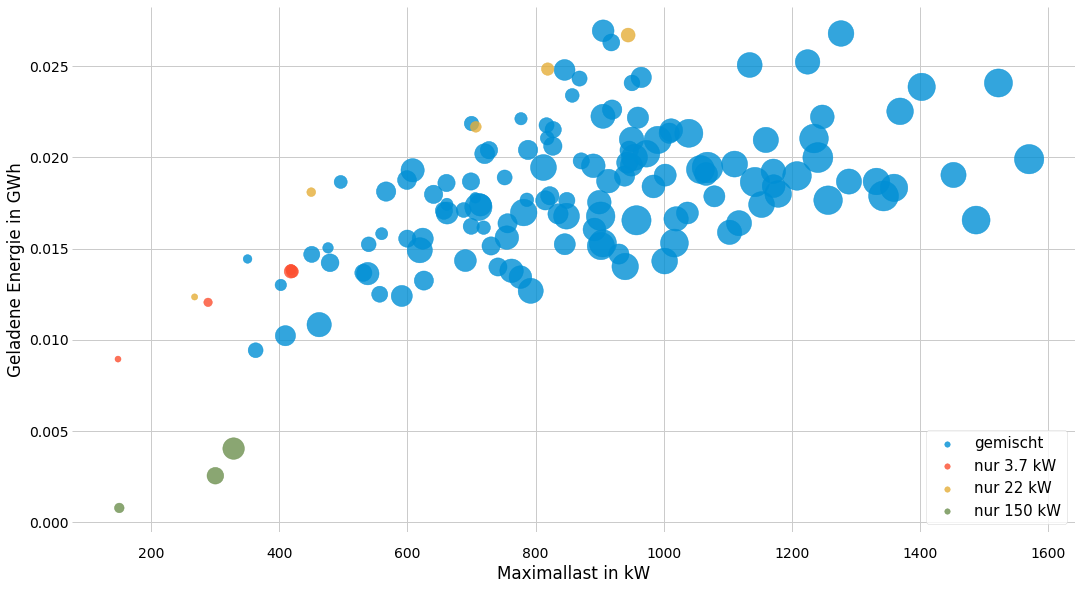

In [17]:
# Design settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['xtick.major.pad']='15'
plt.style.use('fivethirtyeight')

df = df_res

# Put data from pandas DataFrame to arrays
scatter_x = np.array(list(df.max_load))
scatter_y = np.array(list(df.total_energy_charged))

price = np.array(list(df.price)) # used for bubble size
group = np.array(list(df.cluster)) # cluser assignment
cluster_name = {4:'gemischt', 1: 'nur 3.7 kW', 2: 'nur 22 kW', 3: 'nur 150 kW'} # cluster names


fig, ax = plt.subplots(facecolor='white')
fig.set_size_inches(16, 9)
for g in cdict.keys():
    ix = np.where(group == g)
    #ax.scatter(scatter_x[ix], scatter_y[ix], label=cluster_name[g], alpha=0.6) # no size
    ax.scatter(scatter_x[ix], scatter_y[ix], s=price[ix]/2000, label=cluster_name[g], alpha=0.8) # with size


# Legend
lgnd = plt.legend(loc="lower right", scatterpoints=1, fontsize=15, facecolor='white')
for i in range(4):
    lgnd.legendHandles[i]._sizes = [30]

# Axes label
plt.xlabel('Maximallast in kW')
plt.ylabel('Geladene Energie in GWh')
#plt.xlim(900, 1300)
#plt.ylim(2.1, 2.45)


# For point annotations
plt.rcParams.update({'font.size': 8})
for row in list(df.index):
    price_row = round(df.loc[row, 'price']/1000,0)
    cps_low = df.loc[row, 'cps_low']
    cps_middle = df.loc[row, 'cps_middle']
    cps_high = df.loc[row, 'cps_high']
    max_load = df.loc[row, 'max_load']
    tot_ener = df.loc[row, 'total_energy_charged']
    ident = df.loc[row, 'id']
    #ax.annotate(str(price_row)  + '\n' + str(ident), (max_load, tot_ener))
    continue # remove if this should be used
    if row == p1 or row == p2:
        text_to_display = '3.7 kW: ' + str(cps_low) + '\n' + '22 kW: ' + str(cps_middle) + '\n' + '150 kW: ' + str(cps_high)
        ax.annotate(text_to_display, xy=(max_load, tot_ener), xytext=(max_load, tot_ener + 0.025),
            arrowprops=dict(facecolor='black', shrink=0.05), bbox=dict(facecolor='white', edgecolor='grey'))
    elif row == p_high:
        text_to_display = '150 kW: ' + str(cps_high)
        ax.annotate(text_to_display, xy=(max_load + 1.75, tot_ener + 0.002), xytext=(max_load + 10, tot_ener + 0.025),
            arrowprops=dict(facecolor='black', shrink=0.05), bbox=dict(facecolor='white', edgecolor='grey'))
    elif row == p_middle:
        text_to_display = '22 kW: ' + str(cps_middle)
        ax.annotate(text_to_display, xy=(max_load, tot_ener), xytext=(max_load, tot_ener - 0.025),
            arrowprops=dict(facecolor='black', shrink=0.05), bbox=dict(facecolor='white', edgecolor='grey'))

ax.set_facecolor('white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()